In [1]:
import os
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import numpy.ma as ma

In [2]:
file = 2458745
uv = UVData()
uv.read('/lustre/aoc/projects/hera/pstar/autos/'+str(file)+'_autos_sum.uvh5')

In [3]:
print(np.sort(uv.antenna_numbers))

[  0   1   2  11  12  13  14  23  24  25  26  39  84  85  86  87  89  91
 101 102 103 104 105 106 108 120 121 122 123 124 125 126]


In [4]:
freq = uv.freq_array[0]*1e-6
antnums = uv.antenna_numbers
times = np.unique(uv.time_array)

In [7]:
def allauto_waterfall_lineplot (colorbar_min, colorbar_max):
    
    for ant in uv.antenna_numbers:
        freq = uv.freq_array[0]*1e-6
        fig = plt.figure(figsize=(20,20))

        #can use gridspec instead of saying add_subplot(1,2,1) etc
        gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 

        #creates waterfall subplot
        waterfall= plt.subplot(gs[0])

        #create time axis
        jd_ax=plt.gca()

        #there are a lot of redundancies in time_array, so to make sure that we have a list
        #of unique times to work with, we start off by making a new array... not doing this will
        #make things get messy. gave me a blank plot at first with a bunch of lines on the side
        #before i did this.
        times= np.unique(uv.time_array)

        #create the plot. uv.get_data will get data from specified antennas
        #colors.LogNorm() puts colors on log scale
        im = plt.imshow(np.abs(uv.get_data((ant,ant, uv.polarization_array[0]))),norm=colors.LogNorm(), 
                   vmin=colorbar_min, vmax=colorbar_max, aspect='auto')
        waterfall.set_title('Waterfall+Lineplot, Antenna '+str(ant))

        # get an array of frequencies in MHz
        freqs = uv.freq_array[0, :] / 1000000
        xticks = np.arange(0, len(freqs), 120)
        plt.xticks(xticks, labels =np.around(freqs[xticks],2))

        jd_ax.set_ylabel('JD Time (days)')

        #makes equally spaced ticks in increments of 100. since we are assuming time is pretty
        #continuous, this will cover all times pretty well if we go from 0 to the length 
        jd_yticks = np.arange(0,len(times),100)
        #set_yticks takes a List of y-axis tick locations. its purpose is to set tick locations
        jd_ax.set_yticks(jd_yticks)
        #this function actually determines what the tickmarks will say.
        jd_ax.set_yticklabels(np.around(times[jd_yticks],2))


        #create second axis
        lst_ax = jd_ax.twinx()
        lst_ax.set_ylabel('LST Time (hour of the day)')

        #lst_array is in radians, and we want it in *hours*.. rad*180/pi = degrees
        #one hour= 15 degrees
        lst_hours = (uv.lst_array*(180/np.pi))/(15)

        #creates array of unique lsts
        lsts= lst_hours.reshape(uv.Ntimes,uv.Nbls)
        lsts = lsts[:,0]

        #set the ticks of the lst axis to match the lst_array in hours
        lst_yticks = np.arange(0,len(lsts),100)
        lst_ax.set_yticks(lst_yticks)
        lst_ax.set_yticklabels(np.around(lsts[lst_yticks],2))

        #gives the lst_axis information about the jd_axis. stuff like the y-dimension of the data. 
        #gets the axes to line up properly. will make it so that the tick-marks lining up, and the 
        #zeroth entry of times[jd_yticks] lining up with the zeroth entry of lsts[lst_yticks]
        lst_ax.set_ylim(jd_ax.get_ylim())

        #makes it so that the second axis does not alter the structure of the figure
        jd_ax.autoscale(False)
        lst_ax.autoscale(False)

        #creates line subplot and positions it according to gs[1]
        line= plt.subplot(gs[1])

        averaged_data= np.abs(np.average(uv.get_data((1,1, uv.polarization_array[0])),0))

        plt.plot(freq,averaged_data)
        line.set_yscale('log')
        line.set_xlabel('Frequency (MHz)')
        line.set_ylabel('Power')
        #sets the range of the graph to be the same range as waterfall plot
        line.set_xlim(freq[0],freq[-1])


        #makes waterfall x ticks invisible
        plt.setp(waterfall.get_xticklabels(), visible=False)

        #brings plots together
        plt.subplots_adjust(hspace=.0)


        #pad moves colorbar farther from plot
        cbar = plt.colorbar(im, pad= 0.15, orientation = 'horizontal')
        cbar.set_label('Power -->')
        
        #plt.savefig('/lustre/aoc/projects/hera/amyers/gitrepos/monsterDetection/waterfalls/'+
        #            str(file)+'WF_LP_ant'+str(ant))
        plt.show()
        plt.close()
    return;

In [10]:
def every_hour_lineplot(ant):

    fig = plt.figure(figsize=(20,20))

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    #creating hour_array, which has times from time_array that are spaced ~ 1 hour apart 
    hour_arrange = np.arange(times[0],times[-1],(1/24))
    hour_array=[]
    for hour_value in hour_arrange:
        time = find_nearest(times,hour_value)
        hour_array.append(time)

    #setting up the structure of the subplots plots
    nhours = len(hour_array)
    cols = 3
    rows = nhours//cols +1
    i = 1

    #creating the plots
    for time in hour_array:

        plt.subplot(rows,cols,i)

        times_index = np.where(times == time)
        #np.where outputs a tuple. [0] pulls out a single number array, int makes it a number
        #which is not in an array
        times_index = int(times_index[0])

        dat = np.abs(uv.get_data((ant,ant,'xx'))[times_index])

        plt.plot(freq,dat)
        plt.title('Ant '+str(ant)+',  time = '+str(time))
        plt.yscale('log')
        plt.ylim((1e6,1e8))

        #add 1 to i
        i +=1

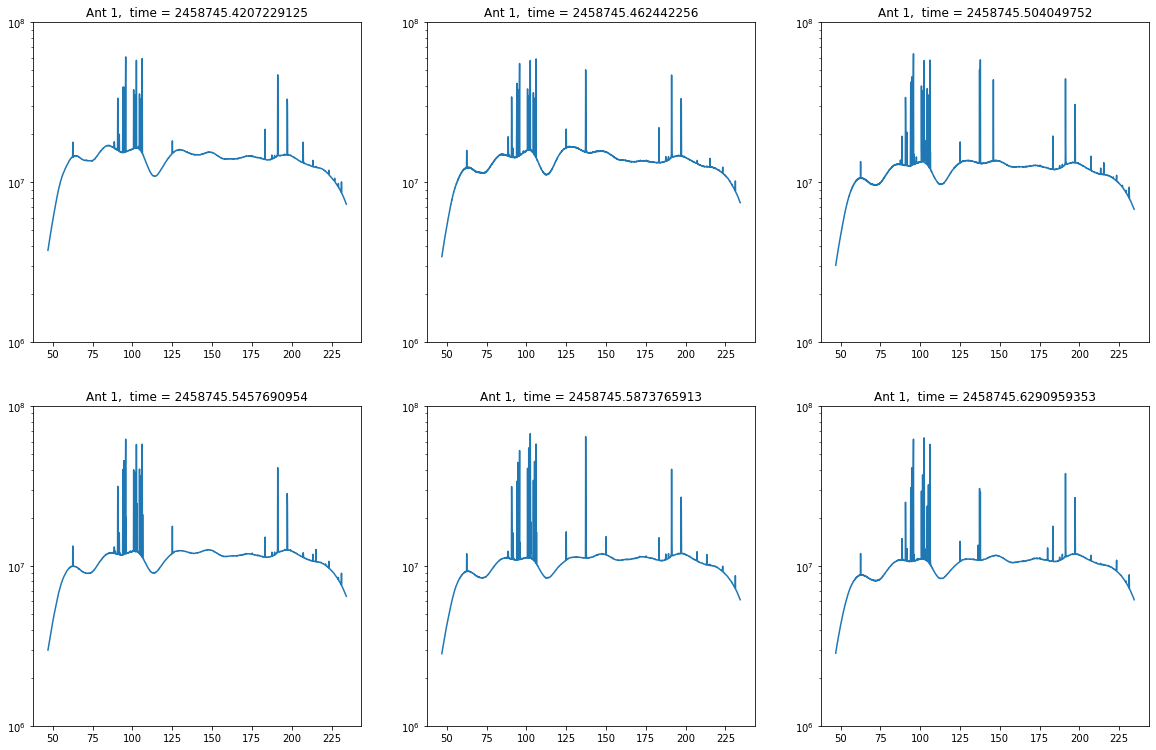

In [12]:
every_hour_lineplot(1)

In [13]:
file = 2458746
uv = UVData()
uv.read('/lustre/aoc/projects/hera/pstar/autos/'+str(file)+'_autos_sum.uvh5')
print(np.sort(uv.antenna_numbers))
freq = uv.freq_array[0]*1e-6
antnums = uv.antenna_numbers
times = np.unique(uv.time_array)

[  0   1   2  11  12  13  14  23  24  25  26  39  84  85  86  87 101 102
 103 104 120 121 122 123]


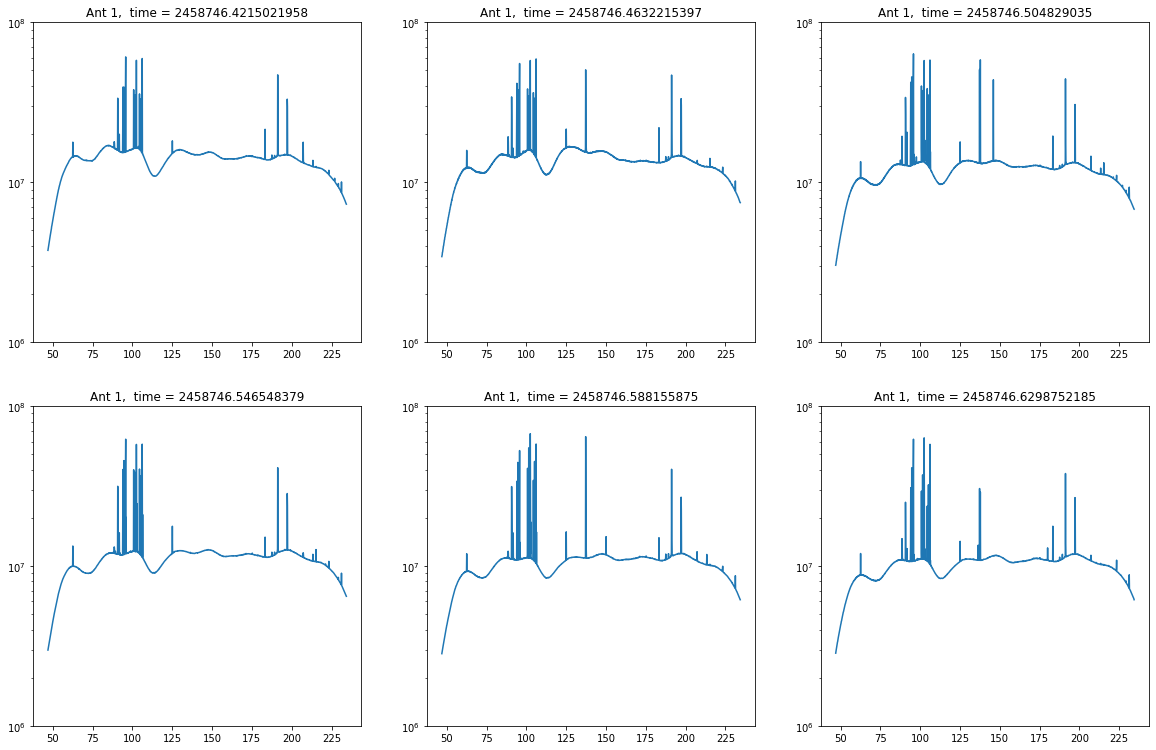

In [14]:
every_hour_lineplot(1)

In [15]:
file = 2458748
uv = UVData()
uv.read('/lustre/aoc/projects/hera/pstar/autos/'+str(file)+'_autos_sum.uvh5')
print(np.sort(uv.antenna_numbers))
freq = uv.freq_array[0]*1e-6
antnums = uv.antenna_numbers
times = np.unique(uv.time_array)

[  0   1   2  11  12  13  14  23  24  25  26  39  84  85  86  87  88  89
  90  91 101 102 103 104 105 106 107 108 120 121 122 123 124 125 126]


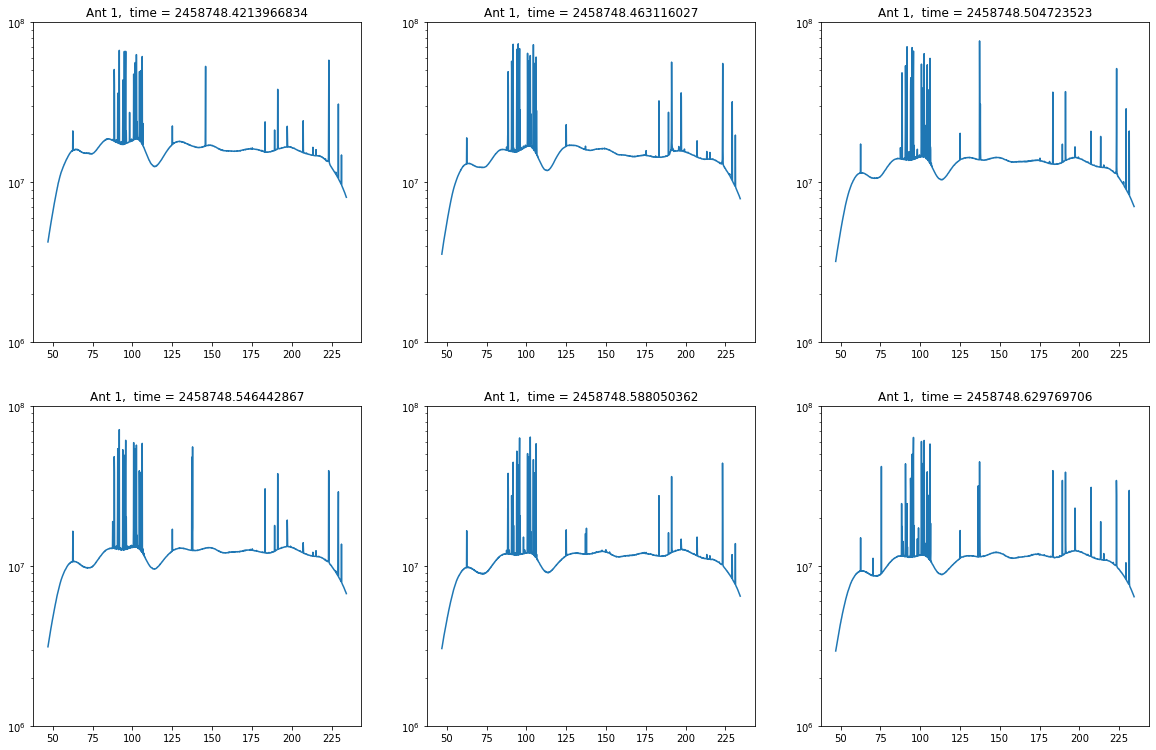

In [16]:
every_hour_lineplot(1)

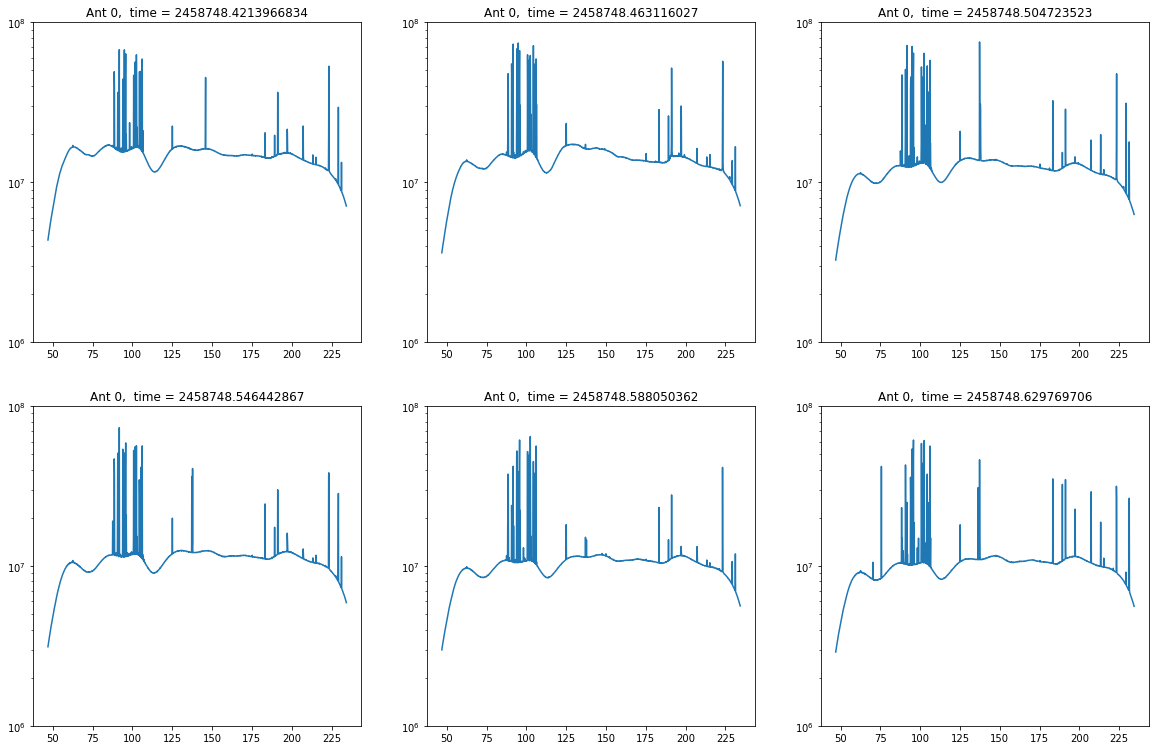

In [17]:
every_hour_lineplot(0)

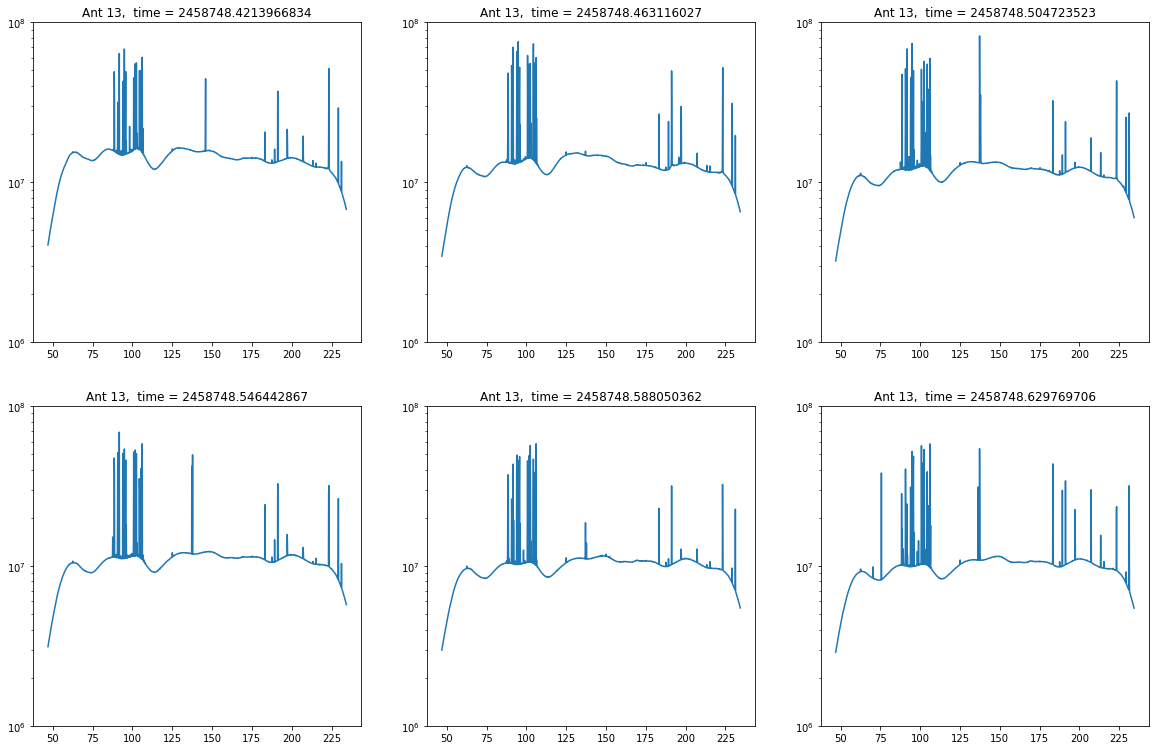

In [18]:
every_hour_lineplot(13)

In [19]:
file = 2458812
uv = UVData()
uv.read('/lustre/aoc/projects/hera/pstar/autos/'+str(file)+'_autos_sum.uvh5')
print(np.sort(uv.antenna_numbers))
freq = uv.freq_array[0]*1e-6
antnums = uv.antenna_numbers
times = np.unique(uv.time_array)

[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -

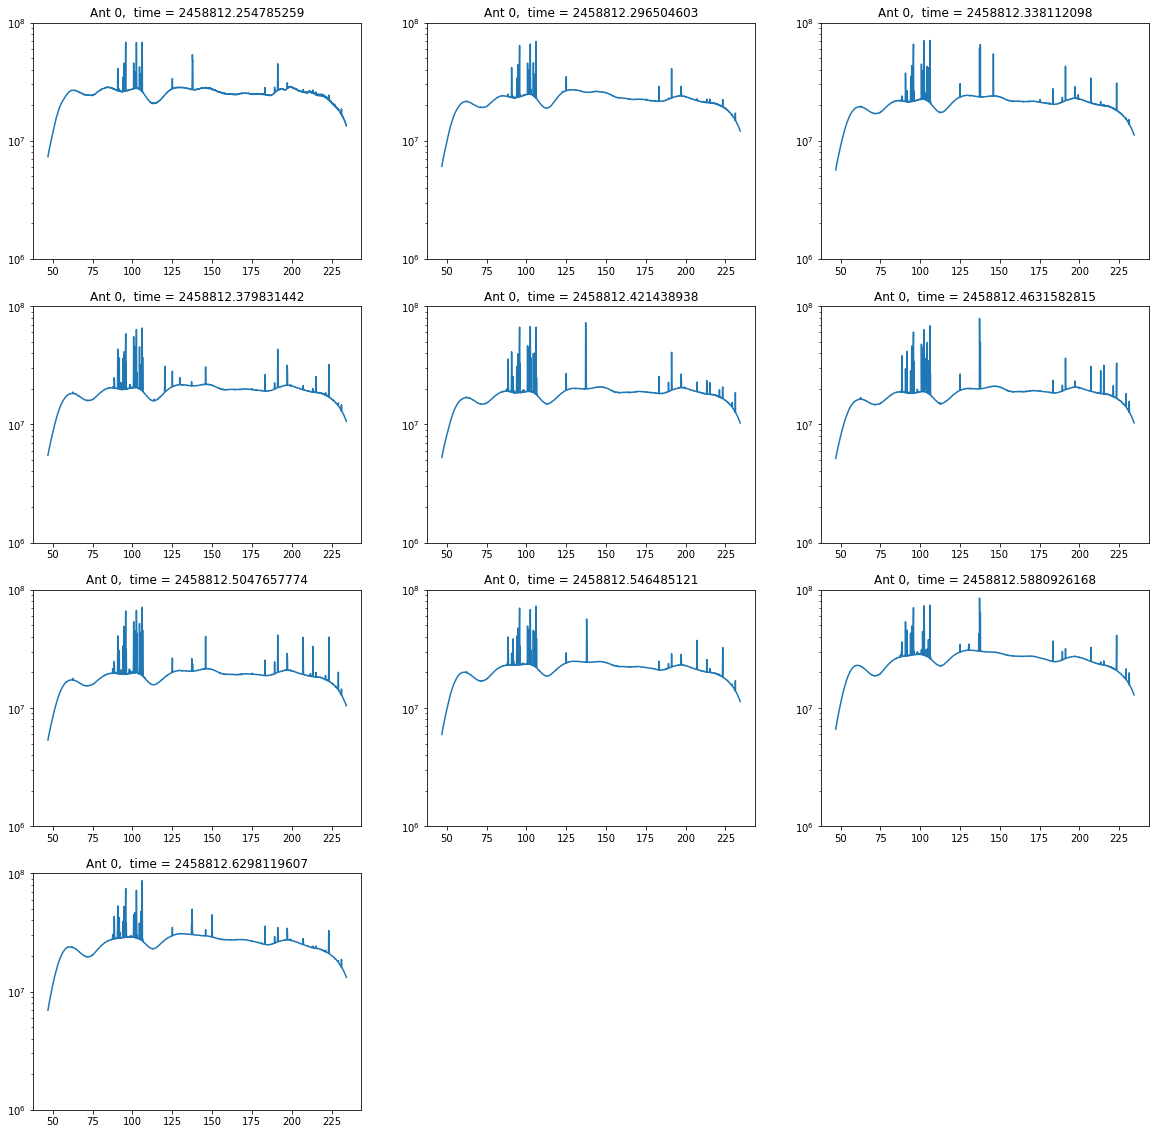

In [20]:
every_hour_lineplot(0)

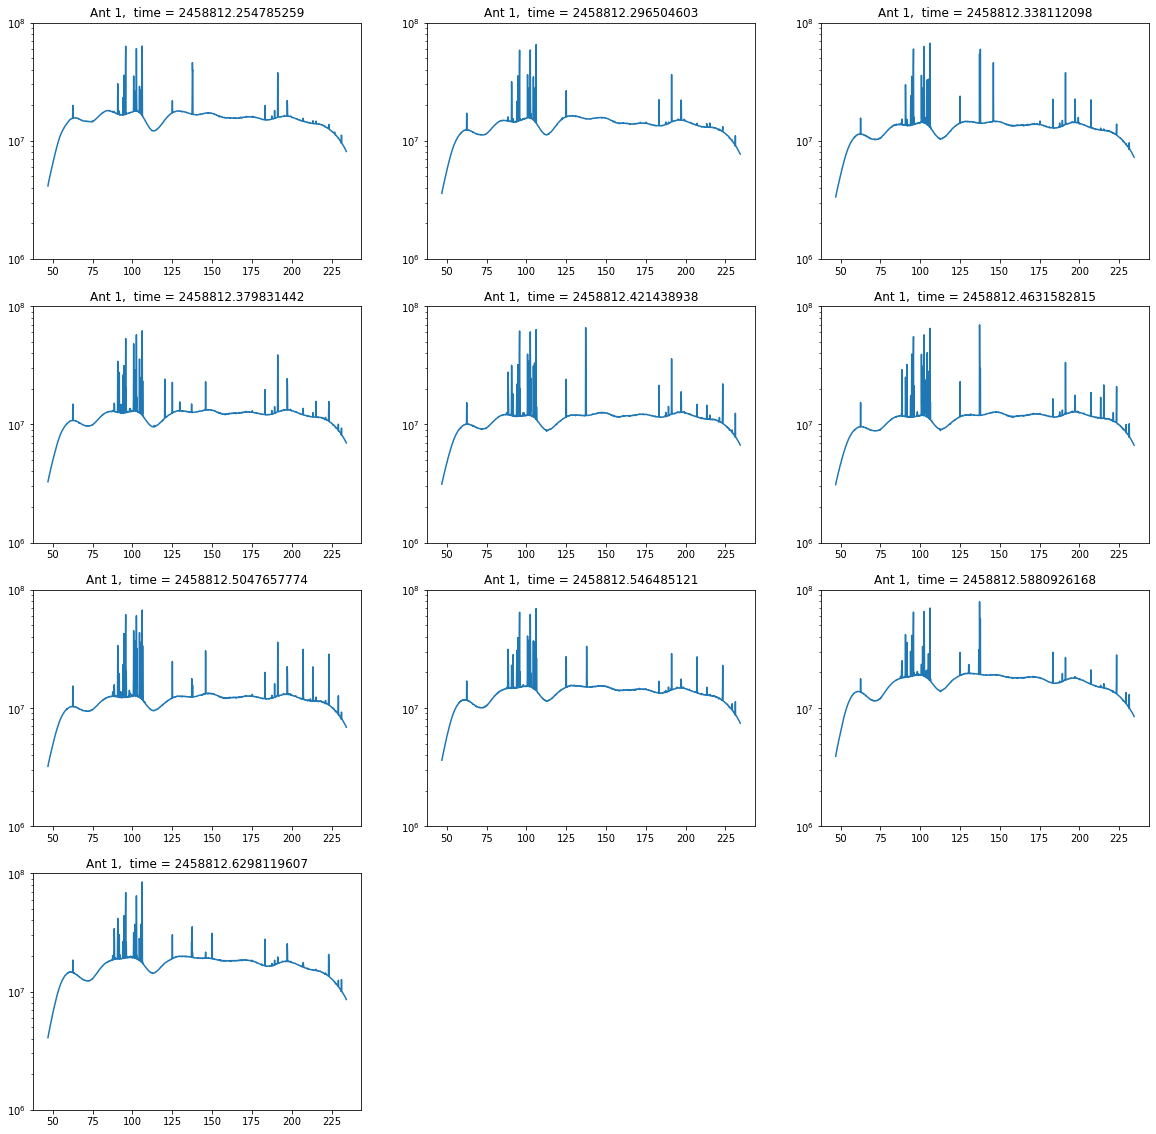

In [21]:
every_hour_lineplot(1)

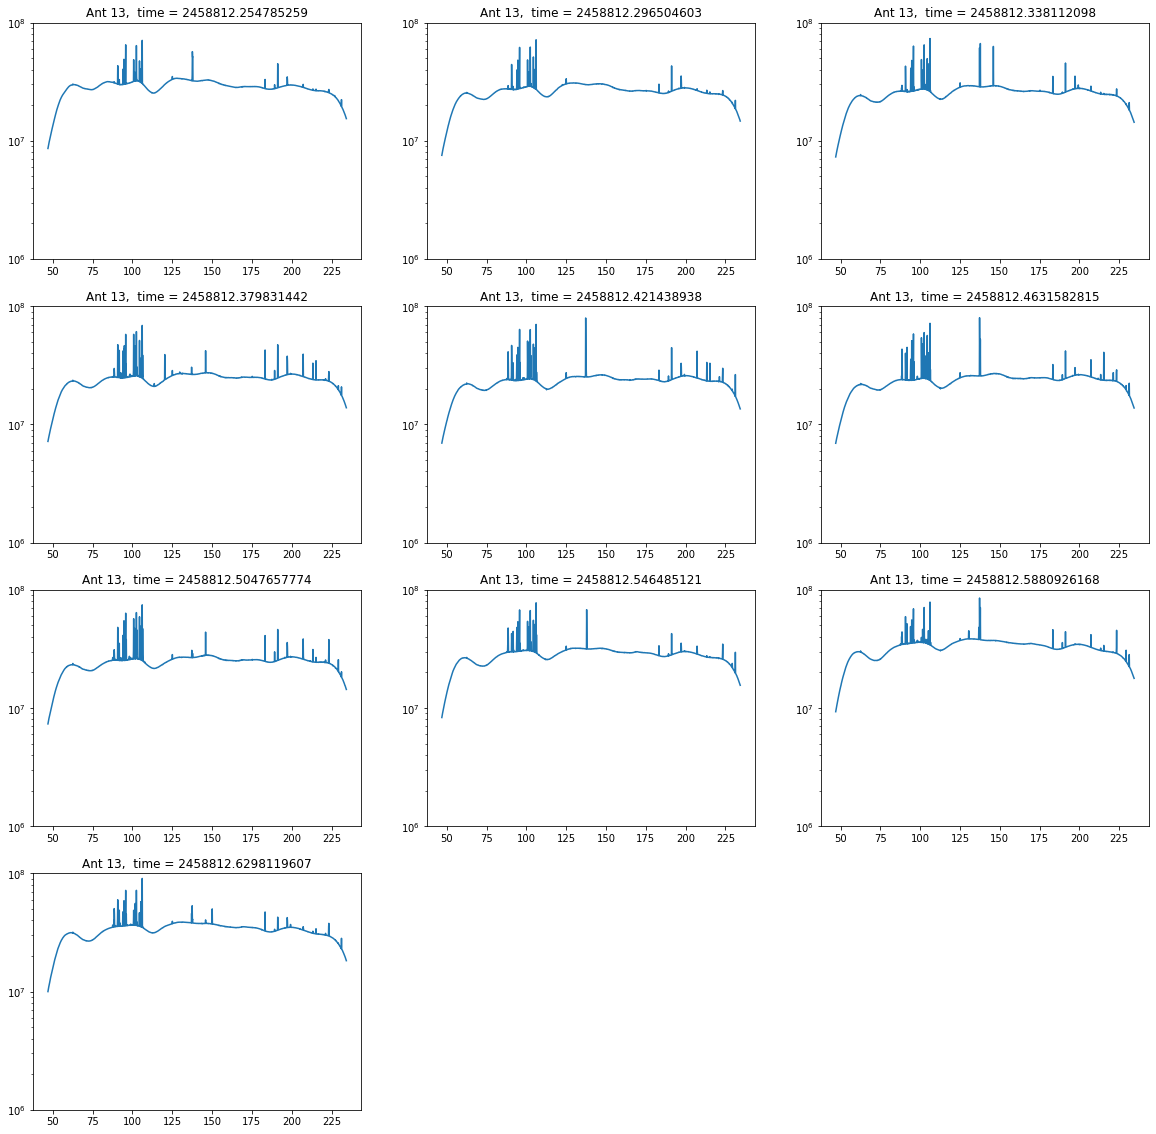

In [22]:
every_hour_lineplot(13)